In [0]:
!pip install mahotas
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import mahotas
from mahotas.features import surf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


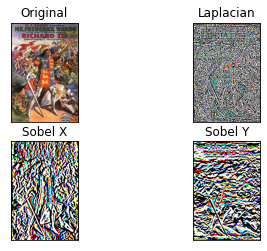

In [0]:
plt.subplot(2,2,1),plt.imshow(ims[0],cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [0]:
def hog(img):
    """
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_svm/py_svm_opencv/py_svm_opencv.html#svm-opencv
    """
    bin_n = 16 # Number of bins
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    # quantizing binvalues in (0...16)
    bins = np.int32(bin_n*ang/(2*np.pi))

    # Divide to 4 sub-squares
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    return hist

# Starting On Our Dataset

In [0]:
import re
import numpy as np
import pandas as pd

import os
from sklearn.model_selection import train_test_split

import urllib.request
from urllib.error import HTTPError

import PIL
from PIL import Image


def read_and_clean_data(path):
    df = pd.read_csv(path, encoding="ISO-8859-1", usecols=["imdbId", "Title", "Genre", "Poster"])
    df.set_index(["imdbId"], inplace=True)
    print(f"Shape of the original dataset: {df.shape}")
    df.dropna(inplace=True)
    print(f"Shape after dropping rows with missing values: {df.shape}")
    df.drop_duplicates(subset="Poster", keep=False, inplace=True)
    print(f"Shape after dropping rows with potentially misleading poster link: {df.shape}\n")
    return df

def add_year_variable(df):
    re_year = re.compile("\((\d{4})\)")
    df["year"] = df.Title.map(lambda x: int(re_year.findall(x)[0]) if re_year.findall(x) else None)
    print(f"There are movies between {int(np.min(df.year))} and {int(np.max(df.year))} available in the dataset.\n")
    return df

def create_boolean_genres(df):
    df["Genre"] = df.Genre.map(lambda x: x.split("|"))
    all_genres = set([item for l in df.Genre for item in l])
    print(f"There are {len(all_genres)} genres in the dataset: {all_genres}\n")
    for genre in all_genres:
        new_var = "is_" + re.sub(r'\W+', '', genre.lower())
        df[new_var] = df.Genre.map(lambda x: genre in x)
    df.drop(["Genre"], axis=1, inplace=True)
    return df

def extract_genre_data(df, genre="Action"):
    filter_var = "is_" + re.sub(r'\W+', '', genre.lower())
    df_genre = df.copy().loc[df[filter_var]]
    print(f"{genre} movies in the dataset: {df_genre.shape[0]}\n")
    return df_genre

def select_years(df, min_year=1950, max_year=2000, add_decades=True):
    df_range = df.copy().loc[(df.year >= min_year) & (df.year < max_year)]
    print(f"Movies left between {min_year} and {max_year}: {df_range.shape[0]}")
    if add_decades:
        df_range["decade"] = df_range.year.apply(lambda x: str(int(x))[2] +"0s")
        print(f"Movies per decade in the dataset:\n{df_range.decade.value_counts()}\n")
    return df_range

def sample_same_number_per_decade(df, use_test_sample=False):
    min_number = 40 if use_test_sample else np.min(df.decade.value_counts())
    df_sample = df.groupby("decade").apply(lambda x: x.sample(min_number))
    print(f"Sample includes {min_number} movies per decade")
    return df_sample

def create_train_and_test_dfs(df, prop_test=.2, strat = 'decade'):
    if strat is not None:
        strat = df[strat]
    train, test = train_test_split(df, test_size=prop_test, stratify=strat)
    print(f"Number of movies in training data: {train.shape[0]}")
    print(f"Number of movies in testing data:  {test.shape[0]}\n")
    return {"train": train, "test": test}

def create_folder_structure(image_folder="movie_posters", splits=["train", "test"], classes=None):
    for s in splits:
        for c in classes:
            folder_name = "/".join([image_folder, s, c])
            try:
                os.makedirs(folder_name)
            except FileExistsError:
                print(f"{folder_name} already exists.")
        print("\n")
        
def download_posters(dfs, image_folder="movie_posters"):
    for k, df in dfs.items():
        print(f"Starting with downloading files for {k}...\n")
        already_downloaded = 0
        http_errors = []
        for index, movie in df.iterrows():
            movie_id = str(index[1])
            movie_decade = index[0]
            file_name = movie_id + ".jpg"
            file_path = "/".join([image_folder, k, movie_decade, file_name])
            if os.path.isfile(file_path):
                already_downloaded += 1
            else:
                try:
                    urllib.request.urlretrieve(movie.Poster, file_path)       
                except HTTPError:
                    http_errors.append(movie_id)
        print(f"{len(http_errors)} posters had an HTTPError.")
        print(f"{already_downloaded} posters were downloaded before.\n")
        count = 0
        for root, dirs, files in os.walk("/".join([image_folder, k])):
            if len(dirs) == 0:
                count += len(files)
                print(f"Number of pictures in {root}:\t{len(files)}")
        print(f"\nTotal number of pictures available for {k}: {count}\n")

def delete_black_and_white_posters(image_folder=None):
    print(f"\nChecking for black and white pictures in {image_folder}...")
    count = 0
    for root, dirs, files in os.walk(image_folder):
        if len(files) > 0:
            for f in files:
                file_path = "/".join([root, f])
                if np.asarray(Image.open(file_path)).shape != (268, 182, 3):
                    os.remove(file_path)
                    count += 1
    print(f"Files without RGB and therefore deleted: {count}")    
    
    
### TO DOWNLOAD ALL ####
def create_all_folders(image_folder="movie_posters",name = 'all', classes=None):
    for c in classes:
        folder_name = "/".join([image_folder, name, c])
        try:
            os.makedirs(folder_name)
        except FileExistsError:
            print(f"{folder_name} already exists.")
    print("\n")
    
def download_all(df, image_folder="movie_posters", name = 'all'):
    if not os.path.exists("/".join([image_folder, name])):
        os.mkdir("/".join([image_folder, name]))
    print(f"Starting with all downloading files..\n")
    already_downloaded = 0
    http_errors = []
    for index, movie in df.iterrows():
        movie_id = str(index[1])
        movie_decade = index[0]
        file_name = movie_id + ".jpg"
        file_path = "/".join([image_folder, name, movie_decade, file_name])
        if os.path.isfile(file_path):
            already_downloaded += 1
        else:
            try:
                urllib.request.urlretrieve(movie.Poster, file_path)       
            except HTTPError:
                http_errors.append(movie_id)
    print(f"{len(http_errors)} posters had an HTTPError.")
    print(f"{already_downloaded} posters were downloaded before.\n")
    count = 0
    for root, dirs, files in os.walk("/".join([image_folder, name])):
        if len(dirs) == 0:
            count += len(files)
            print(f"Number of pictures in {root}:\t{len(files)}")
    #print(f"\nTotal number of pictures available for {k}: {count}\n")

In [8]:
df = read_and_clean_data("https://raw.githubusercontent.com/ucsd-dsc-arts/dsc160-midterm-group-14/master/data/MovieGenre.csv")

Shape of the original dataset: (40108, 3)
Shape after dropping rows with missing values: (39263, 3)
Shape after dropping rows with potentially misleading poster link: (37850, 3)



In [9]:
movie_data = add_year_variable(df)
movie_data = create_boolean_genres(movie_data)
action_movies = extract_genre_data(movie_data, "Action")
action_movies = select_years(action_movies, 1970, 2018)
action_sample = sample_same_number_per_decade(action_movies, use_test_sample=False)

There are movies between 1874 and 2018 available in the dataset.

There are 28 genres in the dataset: {'Musical', 'History', 'Mystery', 'Music', 'Family', 'Game-Show', 'Thriller', 'Animation', 'Horror', 'Drama', 'Film-Noir', 'Comedy', 'Fantasy', 'Talk-Show', 'Romance', 'Crime', 'Adult', 'Western', 'Documentary', 'News', 'Sport', 'War', 'Sci-Fi', 'Reality-TV', 'Short', 'Action', 'Adventure', 'Biography'}

Action movies in the dataset: 5133

Movies left between 1970 and 2018: 4614
Movies per decade in the dataset:
10s    1381
00s    1327
90s     855
80s     582
70s     469
Name: decade, dtype: int64

Sample includes 469 movies per decade


In [10]:
image_folder = "movie_posters"
dfs = create_train_and_test_dfs(action_sample)
create_folder_structure(image_folder, dfs.keys(), set(action_sample.decade))
download_posters(dfs)
delete_black_and_white_posters(image_folder)

Number of movies in training data: 1876
Number of movies in testing data:  469





Starting with downloading files for train...

115 posters had an HTTPError.
0 posters were downloaded before.

Number of pictures in movie_posters/train/10s:	374
Number of pictures in movie_posters/train/70s:	346
Number of pictures in movie_posters/train/90s:	352
Number of pictures in movie_posters/train/00s:	353
Number of pictures in movie_posters/train/80s:	336

Total number of pictures available for train: 1761

Starting with downloading files for test...

24 posters had an HTTPError.
0 posters were downloaded before.

Number of pictures in movie_posters/test/10s:	92
Number of pictures in movie_posters/test/70s:	88
Number of pictures in movie_posters/test/90s:	91
Number of pictures in movie_posters/test/00s:	88
Number of pictures in movie_posters/test/80s:	86

Total number of pictures available for test: 445


Checking for black and white pictures in movie_posters...
Files without RGB and therefore d

In [11]:
image_folder = "movie_posters"
create_all_folders(image_folder, classes = set(action_sample.decade))
download_all(action_sample)



Starting with all downloading files..

139 posters had an HTTPError.
0 posters were downloaded before.

Number of pictures in movie_posters/all/10s:	466
Number of pictures in movie_posters/all/70s:	434
Number of pictures in movie_posters/all/90s:	443
Number of pictures in movie_posters/all/00s:	441
Number of pictures in movie_posters/all/80s:	422


In [12]:
cd "/content/movie_posters/all/00s"

/content/movie_posters/all/00s


In [0]:
ids = []
ims = []
indices = []
laplacians = []
sobelxs = []
sobelys = []
hogs = []
haralicks = []
lbps = []
pftas = []
zernlikes = []
cooccurences = []
full_hists = []
surf_points = []
for i in os.listdir():
  ids.append(i.split(".")[0])
  im = Image.open(i)
  ims.append(im)
  index = np.array(im)
  indices.append(index)
  laplacian = cv2.Laplacian(index, cv2.CV_64F)
  laplacians.append(laplacian)
  sobelx = cv2.Sobel(index, cv2.CV_64F, 1, 0, ksize=5)
  sobelxs.append(sobelx)
  sobely = cv2.Sobel(index, cv2.CV_64F, 0, 1, ksize=5)
  sobelys.append(sobely)
  im_hog = hog(index)
  hogs.append(im_hog)
  haralick = mahotas.features.haralick(index)
  haralicks.append(haralick)
  lbp = mahotas.features.lbp(mahotas.colors.rgb2grey(index), 8, 6) # Randomly selected 8 and 6
  lbps.append(lbp)
  pfta = mahotas.features.pftas(index)
  pftas.append(pfta)
  zernlike = mahotas.features.zernike_moments(mahotas.colors.rgb2grey(index), radius = 8) # Randomly selected any int for radius
  zernlikes.append(zernlike)
  coocc = mahotas.features.texture.cooccurence(index, direction = 8) # Randomly selected any int for direction
  cooccurences.append(coocc)
  fh = mahotas.histogram.fullhistogram(index)
  full_hists.append(fh)
  surf_point = surf.surf(mahotas.colors.rgb2grey(index))
  surf_points.append(surf_point)

In [0]:
df = pd.DataFrame()
#df["Image"] = ims
df["ID"] = ids
df["Index"] = indices
df["Laplacian"] = laplacians
df["Sobel X"] = sobelxs
df["Sobel Y"] = sobelys
df["Hog"] = hogs
df["Haralick"] = haralicks
df["LBP"] = lbps
df["PFTA"] = pftas
df["Zernike Moments"] = zernlikes
df["Cooccurences"] = cooccurences
df["Full Histograms"] = full_hists
df["Surf Points"] = surf_points

In [25]:
df.head()

,ID,Index,Laplacian,Sobel X,Sobel Y,Hog,Haralick,LBP,PFTA,Zernlike Moments,Cooccurences,Full Histograms,Surf Points
0,304584,"[[[12, 9, 16], [3, 9, 21], [0, 12, 31], [0, 14...","[[[-20.0, 2.0, 30.0], [6.0, 5.0, 19.0], [3.0, ...","[[[0.0, 0.0, 0.0], [-378.0, 206.0, 490.0], [-2...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[2315.889175415039, 229.87722861766815, 137.98...","[[0.005980902001379807, 990.4596726619197, 0.9...","[5952.0, 7343.0, 5516.0, 2484.0, 5683.0, 886.0...","[0.5937674874090655, 0.028959149412423054, 0.0...","[0.3183098861837905, 0.030676202725965267, 0.0...","[[9374, 1948, 1549, 802, 800, 684, 499, 476, 3...","[15526, 4105, 2990, 2449, 2032, 2013, 1494, 15...","[[51.492021347205494, 43.13934569530262, 1.780..."
1,1136608,"[[[159, 147, 167], [159, 147, 167], [159, 147,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 240.0, 0.0, 0.0, 0.0, 0.0...","[[0.000681236814391, 733.4960763331551, 0.9380...","[6329.0, 7176.0, 6168.0, 1955.0, 5440.0, 1361....","[0.7396776638608529, 0.013703275222403957, 0.0...","[0.31830988618379075, 0.029108276877185472, 0....","[[1528, 393, 317, 307, 310, 276, 262, 191, 187...","[5253, 1709, 1256, 1273, 1285, 1171, 1217, 115...","[[73.2620480150022, 106.06441522758374, 1.9052..."
2,367478,"[[[66, 1, 5], [78, 6, 7], [101, 16, 11], [126,...","[[[10.0, 8.0, -2.0], [-5.0, -7.0, -8.0], [-22....","[[[0.0, 0.0, 0.0], [1688.0, 568.0, 152.0], [26...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[3583.9626264572144, 2296.110914707184, 1515.7...","[[0.00522533225847034, 1111.9864455145357, 0.9...","[4888.0, 6608.0, 6725.0, 1865.0, 7987.0, 737.0...","[0.583013223646191, 0.021271713634972975, 0.02...","[0.3183098861837907, 0.07012834360329176, 0.04...","[[4882, 1245, 1245, 1029, 941, 776, 698, 641, ...","[16724, 3436, 3485, 3217, 2978, 2556, 2209, 20...","[[161.19759110216083, 60.99767623518984, 1.968..."
3,351977,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.283472746570505, 598.1499362061161, 0.9678...","[25498.0, 2627.0, 2350.0, 1103.0, 3396.0, 328....","[0.7121765601217656, 0.006678082191780822, 0.0...","[0.3183098861837905, 0.02632877563733532, 0.01...","[[346, 101, 100, 103, 103, 99, 62, 87, 76, 71,...","[2426, 477, 520, 510, 643, 598, 513, 624, 669,...","[[238.85774222247204, 103.75137862708155, 1.86..."
4,465602,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.037167533456551424, 903.0603092288486, 0.9...","[11500.0, 6063.0, 5149.0, 1719.0, 5416.0, 645....","[0.7818235448348191, 0.01837528404125153, 0.01...","[0.31830988618379064, 0.11886357449946232, 0.0...","[[1134, 684, 470, 358, 408, 363, 361, 297, 241...","[6735, 2027, 1942, 2242, 2922, 2566, 2312, 213...","[[147.8394522056521, 132.5028198875132, 2.5008..."


In [33]:
mahotas.features.haralick(df["Index"][0], return_mean = True) # Another option for Haralick

array([ 3.86838594e-03,  2.89008746e+03,  7.72920511e-01,  6.39597379e+03,
        1.37701661e-01,  1.79722191e+02,  2.26938077e+04,  8.50539688e+00,
        1.35949410e+01,  8.31201901e-05,  6.34073340e+00, -1.60495252e-01,
        9.42161973e-01])

In [40]:
movie_data = movie_data.reset_index()
movie_data.head()

,imdbId,Title,Poster,year,is_musical,is_history,is_mystery,is_music,is_family,is_gameshow,is_thriller,is_animation,is_horror,is_drama,is_filmnoir,is_comedy,is_fantasy,is_talkshow,is_romance,is_crime,is_adult,is_western,is_documentary,is_news,is_sport,is_war,is_scifi,is_realitytv,is_short,is_action,is_adventure,is_biography
0,114709,Toy Story (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,113497,Jumanji (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
2,113228,Grumpier Old Men (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,114885,Waiting to Exhale (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,113041,Father of the Bride Part II (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [0]:
def get_genres(row):
  genres = []
  for i, j in zip(row.index, row):
    if type(i) == str:
      if "is_" in i:
        if j == True:
          #print(i.partition("_")[-1])
          genres.append(i.partition("_")[-1])
          #print(j)

  return genres

In [76]:
movie_data["Genres"] = movie_data.apply(get_genres, axis = 1)
movie_data.head()

,imdbId,Title,Poster,year,is_musical,is_history,is_mystery,is_music,is_family,is_gameshow,is_thriller,is_animation,is_horror,is_drama,is_filmnoir,is_comedy,is_fantasy,is_talkshow,is_romance,is_crime,is_adult,is_western,is_documentary,is_news,is_sport,is_war,is_scifi,is_realitytv,is_short,is_action,is_adventure,is_biography,Genres
0,114709,Toy Story (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,"[animation, comedy, adventure]"
1,113497,Jumanji (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,"[family, action, adventure]"
2,113228,Grumpier Old Men (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[comedy, romance]"
3,114885,Waiting to Exhale (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[drama, comedy, romance]"
4,113041,Father of the Bride Part II (1995),https://images-na.ssl-images-amazon.com/images...,1995.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,"[family, comedy, romance]"


In [45]:
df["ID"] = df["ID"].astype(int)
#df["ID"]

0       304584
1      1136608
2       367478
3       351977
4       465602
        ...   
436     250720
437    1208647
438     421974
439    1119178
440     271367
Name: ID, Length: 441, dtype: int64

In [77]:
merged_data = movie_data.merge(df, left_on = "imdbId", right_on = "ID")
merged_data

,imdbId,Title,Poster,year,is_musical,is_history,is_mystery,is_music,is_family,is_gameshow,is_thriller,is_animation,is_horror,is_drama,is_filmnoir,is_comedy,is_fantasy,is_talkshow,is_romance,is_crime,is_adult,is_western,is_documentary,is_news,is_sport,is_war,is_scifi,is_realitytv,is_short,is_action,is_adventure,is_biography,Genres,ID,Index,Laplacian,Sobel X,Sobel Y,Hog,Haralick,LBP,PFTA,Zernlike Moments,Cooccurences,Full Histograms,Surf Points
0,165929,Romeo Must Die (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[thriller, crime, action]",165929,"[[[14, 14, 12], [11, 11, 9], [7, 7, 5], [7, 7,...","[[[-18.0, -18.0, -18.0], [-13.0, -13.0, -13.0]...","[[[0.0, 0.0, 0.0], [-260.0, -260.0, -240.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[216.0, 25.131041169166565, 42.8475456237793, ...","[[0.030308928798558, 738.3249715328368, 0.9415...","[8015.0, 7830.0, 6464.0, 1914.0, 6455.0, 845.0...","[0.8585906235504085, 0.00696590167543301, 0.01...","[0.31830988618379075, 0.17162662917587487, 0.1...","[[5458, 2767, 3323, 1853, 1406, 928, 811, 608,...","[16051, 7124, 28535, 6376, 3610, 2878, 2750, 1...","[[108.32298703755303, 72.96816155400548, 1.859..."
1,192614,The Skulls (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[drama, crime, action]",192614,"[[[171, 143, 96], [175, 146, 102], [176, 147, ...","[[[6.0, 2.0, 14.0], [-1.0, 0.0, 5.0], [-4.0, -...","[[[0.0, 0.0, 0.0], [294.0, 266.0, 580.0], [-44...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[370.0799102783203, 225.2750301361084, 511.765...","[[0.030121860886906368, 194.7653276810579, 0.9...","[7412.0, 8349.0, 6794.0, 2102.0, 6592.0, 875.0...","[0.908508268109547, 0.008231941088815265, 0.01...","[0.3183098861837909, 0.010586462993914934, 0.0...","[[744, 242, 214, 247, 292, 307, 310, 342, 314,...","[4293, 1384, 1475, 1942, 2819, 3957, 8070, 161...","[[160.81376597631797, 33.03524078843191, 1.848..."
2,141926,U-571 (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,"[war, action]",141926,"[[[197, 207, 206], [210, 220, 219], [220, 230,...","[[[52.0, 52.0, 52.0], [1.0, 1.0, 1.0], [-23.0,...","[[[0.0, 0.0, 0.0], [422.0, 414.0, 418.0], [408...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[756.0383605957031, 664.7653608322144, 633.313...","[[0.007805193444355462, 227.90258742505938, 0....","[7473.0, 7339.0, 8242.0, 1616.0, 8048.0, 766.0...","[0.8740747405183907, 0.006968584117844319, 0.0...","[0.3183098861837906, 0.006563879601565341, 0.0...","[[498, 387, 337, 922, 977, 4177, 1215, 495, 37...","[10367, 5231, 2363, 1977, 2716, 5878, 2886, 16...","[[162.34824733066222, 62.04918551876825, 1.974..."
3,185183,Battlefield Earth (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,"[scifi, action, adventure]",185183,"[[[51, 162, 207], [45, 154, 197], [43, 154, 19...","[[[-8.0, -10.0, -12.0], [10.0, 20.0, 28.0], [1...","[[[0.0, 0.0, 0.0], [-144.0, -22.0, 10.0], [60....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1309.0376615524292, 825.1249008178711, 799.95...","[[0.0008361201128792065, 523.469426952573, 0.9...","[5618.0, 7352.0, 5837.0, 2190.0, 6165.0, 958.0...","[0.8174986457928025, 0.0126952156431912, 0.014...","[0.31830988618379086, 0.08182393685451958, 0.0...","[[276, 126, 190, 154, 160, 136, 129, 123, 100,...","[3139, 780, 1222, 1166, 1384, 1

In [89]:
merged_data["Hog Mean"] = merged_data["Hog"].apply(np.mean)
merged_data.head()

,imdbId,Title,Poster,year,is_musical,is_history,is_mystery,is_music,is_family,is_gameshow,is_thriller,is_animation,is_horror,is_drama,is_filmnoir,is_comedy,is_fantasy,is_talkshow,is_romance,is_crime,is_adult,is_western,is_documentary,is_news,is_sport,is_war,is_scifi,is_realitytv,is_short,is_action,is_adventure,is_biography,Genres,ID,Index,Laplacian,Sobel X,Sobel Y,Hog,Haralick,LBP,PFTA,Zernlike Moments,Cooccurences,Full Histograms,Surf Points,Hog Mean
0,165929,Romeo Must Die (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[thriller, crime, action]",165929,"[[[14, 14, 12], [11, 11, 9], [7, 7, 5], [7, 7,...","[[[-18.0, -18.0, -18.0], [-13.0, -13.0, -13.0]...","[[[0.0, 0.0, 0.0], [-260.0, -260.0, -240.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[216.0, 25.131041169166565, 42.8475456237793, ...","[[0.030308928798558, 738.3249715328368, 0.9415...","[8015.0, 7830.0, 6464.0, 1914.0, 6455.0, 845.0...","[0.8585906235504085, 0.00696590167543301, 0.01...","[0.31830988618379075, 0.17162662917587487, 0.1...","[[5458, 2767, 3323, 1853, 1406, 928, 811, 608,...","[16051, 7124, 28535, 6376, 3610, 2878, 2750, 1...","[[108.32298703755303, 72.96816155400548, 1.859...",251133.614366
1,192614,The Skulls (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[drama, crime, action]",192614,"[[[171, 143, 96], [175, 146, 102], [176, 147, ...","[[[6.0, 2.0, 14.0], [-1.0, 0.0, 5.0], [-4.0, -...","[[[0.0, 0.0, 0.0], [294.0, 266.0, 580.0], [-44...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[370.0799102783203, 225.2750301361084, 511.765...","[[0.030121860886906368, 194.7653276810579, 0.9...","[7412.0, 8349.0, 6794.0, 2102.0, 6592.0, 875.0...","[0.908508268109547, 0.008231941088815265, 0.01...","[0.3183098861837909, 0.010586462993914934, 0.0...","[[744, 242, 214, 247, 292, 307, 310, 342, 314,...","[4293, 1384, 1475, 1942, 2819, 3957, 8070, 161...","[[160.81376597631797, 33.03524078843191, 1.848...",128721.879320
2,141926,U-571 (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,"[war, action]",141926,"[[[197, 207, 206], [210, 220, 219], [220, 230,...","[[[52.0, 52.0, 52.0], [1.0, 1.0, 1.0], [-23.0,...","[[[0.0, 0.0, 0.0], [422.0, 414.0, 418.0], [408...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[756.0383605957031, 664.7653608322144, 633.313...","[[0.007805193444355462, 227.90258742505938, 0....","[7473.0, 7339.0, 8242.0, 1616.0, 8048.0, 766.0...","[0.8740747405183907, 0.006968584117844319, 0.0...","[0.3183098861837906, 0.006563879601565341, 0.0...","[[498, 387, 337, 922, 977, 4177, 1215, 495, 37...","[10367, 5231, 2363, 1977, 2716, 5878, 2886, 16...","[[162.34824733066222, 62.04918551876825, 1.974...",133590.755131
3,185183,Battlefield Earth (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,"[scifi, action, adventure]",185183,"[[[51, 162, 207], [45, 154, 197], [43, 154, 19...","[[[-8.0, -10.0, -12.0], [10.0, 20.0, 28.0], [1...","[[[0.0, 0.0, 0.0], [-144.0, -22.0, 10.0], [60....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1309.0376615524292, 825.1249008178711, 799.95...","[[0.0008361201128792065, 523.469426952573, 0.9...","[5618.0, 7352.0, 5837.0, 2190.0, 6165.0, 958.0...","[0.8174986457928025, 0.0126952156431912, 0.014...","[0.31830988618379086, 0.08182393685451958, 0.0...","[[276, 126, 190, 154, 160, 136, 

In [100]:
merged_data["Zernike Moments Mean"] = merged_data["Zernike Moments"].apply(np.mean)
merged_data.head()

,imdbId,Title,Poster,year,is_musical,is_history,is_mystery,is_music,is_family,is_gameshow,is_thriller,is_animation,is_horror,is_drama,is_filmnoir,is_comedy,is_fantasy,is_talkshow,is_romance,is_crime,is_adult,is_western,is_documentary,is_news,is_sport,is_war,is_scifi,is_realitytv,is_short,is_action,is_adventure,is_biography,Genres,ID,Index,Laplacian,Sobel X,Sobel Y,Hog,Haralick,LBP,PFTA,Zernlike Moments,Cooccurences,Full Histograms,Surf Points,Hog Mean,Zernlike Moments Mean
0,165929,Romeo Must Die (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[thriller, crime, action]",165929,"[[[14, 14, 12], [11, 11, 9], [7, 7, 5], [7, 7,...","[[[-18.0, -18.0, -18.0], [-13.0, -13.0, -13.0]...","[[[0.0, 0.0, 0.0], [-260.0, -260.0, -240.0], [...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[216.0, 25.131041169166565, 42.8475456237793, ...","[[0.030308928798558, 738.3249715328368, 0.9415...","[8015.0, 7830.0, 6464.0, 1914.0, 6455.0, 845.0...","[0.8585906235504085, 0.00696590167543301, 0.01...","[0.31830988618379075, 0.17162662917587487, 0.1...","[[5458, 2767, 3323, 1853, 1406, 928, 811, 608,...","[16051, 7124, 28535, 6376, 3610, 2878, 2750, 1...","[[108.32298703755303, 72.96816155400548, 1.859...",251133.614366,0.075051
1,192614,The Skulls (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,"[drama, crime, action]",192614,"[[[171, 143, 96], [175, 146, 102], [176, 147, ...","[[[6.0, 2.0, 14.0], [-1.0, 0.0, 5.0], [-4.0, -...","[[[0.0, 0.0, 0.0], [294.0, 266.0, 580.0], [-44...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[370.0799102783203, 225.2750301361084, 511.765...","[[0.030121860886906368, 194.7653276810579, 0.9...","[7412.0, 8349.0, 6794.0, 2102.0, 6592.0, 875.0...","[0.908508268109547, 0.008231941088815265, 0.01...","[0.3183098861837909, 0.010586462993914934, 0.0...","[[744, 242, 214, 247, 292, 307, 310, 342, 314,...","[4293, 1384, 1475, 1942, 2819, 3957, 8070, 161...","[[160.81376597631797, 33.03524078843191, 1.848...",128721.879320,0.028727
2,141926,U-571 (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,"[war, action]",141926,"[[[197, 207, 206], [210, 220, 219], [220, 230,...","[[[52.0, 52.0, 52.0], [1.0, 1.0, 1.0], [-23.0,...","[[[0.0, 0.0, 0.0], [422.0, 414.0, 418.0], [408...","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[756.0383605957031, 664.7653608322144, 633.313...","[[0.007805193444355462, 227.90258742505938, 0....","[7473.0, 7339.0, 8242.0, 1616.0, 8048.0, 766.0...","[0.8740747405183907, 0.006968584117844319, 0.0...","[0.3183098861837906, 0.006563879601565341, 0.0...","[[498, 387, 337, 922, 977, 4177, 1215, 495, 37...","[10367, 5231, 2363, 1977, 2716, 5878, 2886, 16...","[[162.34824733066222, 62.04918551876825, 1.974...",133590.755131,0.035668
3,185183,Battlefield Earth (2000),https://images-na.ssl-images-amazon.com/images...,2000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,"[scifi, action, adventure]",185183,"[[[51, 162, 207], [45, 154, 197], [43, 154, 19...","[[[-8.0, -10.0, -12.0], [10.0, 20.0, 28.0], [1...","[[[0.0, 0.0, 0.0], [-144.0, -22.0, 10.0], [60....","[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...","[1309.0376615524292, 825.1249008178711, 799.95...","[[0.0008361201128792065, 523.469426952573, 0.9...","[5618.0, 7352.0, 5837.0, 2190.0, 6165.0, 958.0...","[0.8174986457928025, 0.0126952156431912, 0.014...","[0.31830988618379086, 0.08182393685

In [97]:
merged_data.corr()["Hog Mean"].sort_values(ascending = False)[1:].drop(["ID", "imdbId", "year"])

is_comedy         0.179128
is_animation      0.166584
is_family         0.052968
is_musical        0.042622
is_music          0.032070
is_romance        0.030391
is_documentary    0.017987
is_history        0.017381
is_adventure      0.009708
is_western       -0.011378
is_horror        -0.023615
is_sport         -0.025932
is_short         -0.028562
is_thriller      -0.029226
is_drama         -0.037083
is_crime         -0.047680
is_biography     -0.051702
is_scifi         -0.061930
is_war           -0.089384
is_mystery       -0.104827
is_fantasy       -0.140652
is_gameshow            NaN
is_filmnoir            NaN
is_talkshow            NaN
is_adult               NaN
is_news                NaN
is_realitytv           NaN
is_action              NaN
Name: Hog Mean, dtype: float64

In [102]:
merged_data.corr()["Zernike Moments Mean"].sort_values(ascending = False)[1:].drop(["ID", "imdbId", "year"])

is_thriller       0.131844
is_mystery        0.108175
Hog Mean          0.083776
is_comedy         0.059378
is_horror         0.044677
is_fantasy        0.030765
is_crime          0.021068
is_sport          0.012765
is_adventure      0.010145
is_family         0.000792
is_western       -0.005865
is_scifi         -0.014959
is_biography     -0.026881
is_musical       -0.032815
is_animation     -0.040517
is_romance       -0.042393
is_documentary   -0.051211
is_war           -0.052885
is_short         -0.058961
is_music         -0.060181
is_history       -0.067433
is_drama         -0.086817
is_gameshow            NaN
is_filmnoir            NaN
is_talkshow            NaN
is_adult               NaN
is_news                NaN
is_realitytv           NaN
is_action              NaN
Name: Zernlike Moments Mean , dtype: float64

In [111]:
mahotas.features.haralick(merged_data["Index"][0]).mean(0) # 13 features - http://murphylab.web.cmu.edu/publications/boland/boland_node26.html

array([ 2.61655737e-02,  9.40471372e+02,  9.25027402e-01,  6.27397366e+03,
        3.20777068e-01,  1.16237187e+02,  2.41554233e+04,  7.17248216e+00,
        1.06531209e+01,  3.34138141e-04,  4.84167641e+00, -2.80813144e-01,
        9.81440832e-01])